# 基于MLP的Kaggle房价预测任务

该工作是《深度学习基础》选修课程的系列作业之一。

| 姓名 | 学号 | 贡献比重 | 分工 |
| :--: | :--: | :--: | :--: |
| 张益宁 | 1120200827 | 25% | 感知机设计、基本框架构建 |
| 方辰 | 1120200731 | 0% |  |
| 安禹堃 | 1120200860 | 25% | K折验证、美化排版、可视化 |
| 郑子帆 | 1120200820 | 25% | 参数实验 |
| 贾昌国 | 1120200664 | 25% | 代码审核和微调、美化排版 |

## 引入

&nbsp;&nbsp;&nbsp;&nbsp;本报告完成了一个基于多层感知机（MLP, *Multi-layer Perceptron*）的房价预测线性回归模型。其中数据集处理采用了Dive into Deep Learning提供的方法（独热编码和特征扩展）；又设计了一个多层感知机（特征数为，使用小批次随机梯度下降进行线性回归，利用多个隐藏层处理特征，最后得到预测房价。


## 数据集

kaggle-house-price 是一个房价预测类的比赛，提供的数据集形式为：
-   **1460**个训练数据
-   **1459**个测试数据
-   **79**个不同的描述房屋的角度（特征）
Kaggle上的房价数据由Bart de Cock于2011年收集。涵盖了2006-2010年期间亚利桑那州埃姆斯市的房价。该房价数据集数据量更大，数据特征更丰富，但又不需要过于复杂的模型。

## 数据下载

&nbsp;&nbsp;&nbsp;&nbsp;首先需要预准备用于获取数据集的函数。`download`函数用于从Kaggle下载对应的数据集（并返回下载数据的文件名），`download_extract`函数用于解压压缩文件。

In [ ]:
import hashlib
import os
import tarfile
import zipfile
import requests

def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)    

## 数据处理

接下来处理从Kaggle上下载的房价数据集。该过程中使用了数据分析和处理第三方库`pandas`。

1. 通过**One-Hot**处理扩展信息
1. 删除掉对房价评估没有意义的`Id`项；
1. 将训练集和测试集的特征分别保存到`train_features`和`test_features`中
1. 再记录下训练集的房价信息，作为`train_labels`

In [ ]:
import pandas as pd
import torch
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

#获取下载的csv文件
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

# 生成所有的特征和标签
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
train_ans = train_data.iloc[:, -1]
numeric_feature = all_features.dtypes[all_features.dtypes != 'object'].index

#对数据进行归一化处理
all_features[numeric_feature] = all_features[numeric_feature].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 处理无效值（NaN）
all_features[numeric_feature] = all_features[numeric_feature].fillna(0)
all_features = pd.get_dummies(all_features, dummy_na=True)
n_train = train_data.shape[0]

#将数据转换为Pytorch张量
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# MLP多层感知机的设计
---
## 网络结构图

*  **隐藏层1**（hidden_size1 = 128）

*  **隐藏层2**（hidden_size2 = 64）

*  **输出层**（output_size = 1，一个回归预测值）

![MLP](https://img-blog.csdnimg.cn/68d53248e4e54692b7aa76060bea3309.png)

In [ ]:
import numpy as np
import random

train_size = train_features.shape[0]   # 训练集大小
test_size = test_features.shape[0]    # 测试集大小
tag_size = train_features.shape[1]    # 训练集特征数量（同时也是输入层的输入）

# 输入层
input_size = tag_size 
# 隐藏层数1
hidden_size1 = 128
# 隐藏层数2
hidden_size2 = 64
# 输出层数，参数
output_size = 1
# 小批量梯度下降
batch_size = 50
# 训练次数
Epoch = 6000
# 学习率
lr = 3.5e-1
# k折验证折数
k = 5             

# 初始化K折训练中的最终参数
best_w1 = torch.randn(input_size,  hidden_size1, requires_grad=True)
best_b1 = torch.zeros(hidden_size1, requires_grad=True)
best_w2 = torch.randn(hidden_size1, hidden_size2, requires_grad=True)
best_b2 = torch.zeros(hidden_size2, requires_grad=True) 
best_w3 = torch.randn(hidden_size2, output_size, requires_grad=True)
best_b3 = torch.zeros(output_size, requires_grad=True)    

# 初始化整个训练的最终参数
ans_w1 = torch.randn(input_size,  hidden_size1, requires_grad=True)
ans_b1 = torch.zeros(hidden_size1, requires_grad=True)
ans_w2 = torch.randn(hidden_size1, hidden_size2, requires_grad=True)
ans_b2 = torch.zeros(hidden_size2, requires_grad=True) 
ans_w3 = torch.randn(hidden_size2, output_size, requires_grad=True)
ans_b3 = torch.zeros(output_size, requires_grad=True) 

## 激活函数与神经网络

准备可能需要的激活函数和多层感知机的网络设计：
*   sigmoid函数 $ {\large \sigma (x) = \frac{1}{1+\exp(-x)}} $

*   tanh函数 $ {\large \tanh(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}} $

*   ReLU函数 $ {\large \text{ReLU}(x) = \max(0,\:x)} $

In [ ]:
def sigmoid(x):  # 激活函数1——sigmoid
    return 1/(1 + torch.exp(-1 * x))


def tanh(x):  # 激活函数2——tanh
    return (1 - torch.exp(-2 * x)) / (1 + torch.exp(-2 * x))


def ReLU(x):  # 激活函数3——ReLU
    temp = torch.zeros_like(x)
    return torch.max(x, temp)


def net(x, w1, w2, w3, b1, b2, b3):  # MLP网络架构
    H1 = ReLU(torch.mm(x, w1) + b1)
    H2 = ReLU(torch.mm(H1, w2) + b2)
    output = torch.mm(H2, w3) + b3
    return output


## 设计特征提取函数

### 小批量梯度下降(mini—batch)
&emsp;训练集的数量为**1460**，在进行梯度下降的时候若一次全部计算，比较耗时。

&emsp;在这里选用 **小批量梯度下降** *(mini—batch)*的方式，设定一个批量大小 *(batch_size)*，一次选取个数据合成矩阵
后续直接利用矩阵进行计算。


mini—batch的好处如下：

*   **减少了随机性**：一个批中的一组数据共同决定了本次梯度的方向，相比一个样本产生的梯度来讲噪音小很多，下降更加稳定。


*   **降低硬件占用**：因为一个小批次的样本数与整个数据集相比要小很多，对于计算机的算力要求、内存要求会大大减少。






In [ ]:
def get_batch(features, labels):
    size = len(features)
    indices = list(range(size))
    random.shuffle(indices)
    for i in range(0, size, batch_size): # 随机选取出给的范围内的一部分返回
        batch_indices = torch.tensor(indices[i: min(i + batch_size, size)])
        return features[batch_indices], labels[batch_indices]

## 设计损失函数
常见的损失函数有：

*   均方差损失 *Mean Squared Error Loss*
*   平均绝对误差损失 *Mean Absolute Error Loss*
*   Huber Loss
*   分位数损失 *Quantile Loss*
*   交叉熵损失 *Cross Entropy Loss*
*   自定义损失函数

 
在不同的训练目标下应该选用不同的损失函数。

&emsp;&emsp;&emsp;&emsp;

在本实验中，考虑以下情形：

*   一栋价值**100W$\$$**的别墅我们预测为**95W$\$$**,与实际交易值的绝对误差为**5W$\$$**。

&emsp;&emsp;&emsp;&emsp;这个模型还算不错。

*   一栋价值**1W$\$$**的别墅我们预测为**2W$\$$**,与实际交易值的绝对误差为**1W$\$$**。

&emsp;&emsp;&emsp;&emsp;这个模型非常的糟糕。


&emsp;对于上述两栋房子的预估，我们发现我们更关注**相对损失** 而不是 **绝对损失**，
因此本次损失函数没用使用标准的**均方误差**(*MSE*)，而是关注了价格预测的对数差异，设计损失函数如下：
&emsp;

$$\large loss = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$
&emsp;

设定损失函数 `get_loss`，利用 `get_loss` 获得的训练集特征和标签的批次进行对比计算结果



In [ ]:
def get_loss(features, labels, w1, w2, w3, b1, b2, b3):
    loss = 0
    ans = torch.clamp(net(features, w1, w2, w3, b1, b2, b3), 1, float('inf'))
    for i in range(batch_size): # 根据上述公式进行loss的求取
        loss += (torch.log(ans[i]) - torch.log(labels[i])) ** 2
    loss = torch.sqrt(torch.div(loss, batch_size))
    return loss

## 设计训练函数
训练部分主要分为以下三个部分：


1.   获取训练特征：利用`get_batch`函数，获取batch信息，得到`train_feature`和`train_label`


2.   计算损失：利用`get_loss`函数，比较我们的模型得出的结果与实际结果之间的相对误差


3.   梯度下降：对loss进行求导，将求导后的结果带回到**MLP**中，微调参数



当然在这些运算的过程中也要记录中间过程变量，方便进行检查及为以后的可视化做准备


**至此，我们的MLP及其相关训练方式完全设定完毕。**

In [ ]:
def train(_train_features, _train_labels, _test_features, _test_labels, w1, w2, w3, b1, b2, b3, Type=0):
    # 训练部分
    global ans_w1, ans_w2, ans_w3, ans_b1, ans_b2, ans_b3
    train_ls, test_ls = [], []
    draw_loss = [[],[]]
    best_loss = 100000
    for epoch in range(Epoch + 1):  # 外循环，里面是下降一次
        _train_feature, _train_label = get_batch(_train_features, _train_labels)
        train_loss = get_loss(_train_feature, _train_label, w1, w2, w3, b1, b2, b3)
        if epoch % 500 == 0:
            # 每训练500次进行一次可视化输出，便于及时了解下降状态
            print("round " + str(epoch) + "  loss ==", train_loss[0].item())  # 可视化
            draw_loss[0].append(epoch)
            draw_loss[1].append(train_loss[0].item())
            # 在验证完毕最后训练的时候还要维护最优值
            if Type == 1 and float(train_loss[0].item()) < best_loss:
                best_loss=float(train_loss[0].item())
                ans_w1 = w1
                ans_b1 = b1
                ans_w2 = w2
                ans_b2 = b2
                ans_w3 = w3
                ans_b3 = b3
        train_loss.backward()
        # 梯度下降过程
        with torch.no_grad():
            for param in [w1, w2, w3, b1, b2, b3]: 
                param -= lr * param.grad
                param.grad.zero_()
        train_ls.append(train_loss)
        # 如果采用的是测试集则需要额外计算test_ls
        if _test_labels is not None:
            _test_feature, _test_label = get_batch(_test_features, _test_labels)
            test_loss = get_loss(_test_feature, _test_label, w1, w2, w3, b1, b2, b3)
            test_ls.append(test_loss)
    draw(draw_loss)
    return train_ls, test_ls

# $K$折交叉验证
---
## 总论
**$K$折交叉验证**是一种选择验证集的办法：

&emsp;&emsp;当我们的训练集样本数量比较少的时候，有可能造成过拟合，导致结果在测试集上的表现低于预期值。而在无法增加训练样本的时候，可以通过$K$折交叉验证，每次分割训练集中不同的一部分作为验证集，有助于模型选择和超参数调整。

该算法包括：

*   定义一个函数，在$K$折交叉验证过程中返回第$i$折的数据。
*   选择第$i$个切片作为验证数据，其余部分作为训练数据。


### 原理

&emsp;&emsp;验证数据取自训练数据，但不参与训练，这样可以相对客观的评估模型对于训练集之外数据的匹配程度。

&emsp;&emsp;模型将原始数据分成K组(K-Fold)，将每个子集数据分别做一次验证集，其余的K-1组子集数据作为训练集，这样会得到K个模型。这K个模型分别在验证集中评估结果，最后的误差加和平均就得到交叉验证误差。

&emsp;&emsp;

### 准备工作

下面定义函数 `get_k_fold_data` 在K折交叉验证过程中返回第i折的数据。

In [ ]:
def get_k_fold_data(i, feature, label):
    fold_size = feature.shape[0] // k
    feature_train, label_train = None, None
    # 对其中的每一折
    for j in range(k):
        index = slice(j * fold_size, (j + 1) * fold_size)
        feature_part, label_part = feature[index, :], label[index]
        # 其中k-1折作为训练集，1折作为验证集
        if j == i:
            feature_valid, label_valid = feature_part, label_part
        elif feature_train is None:
            feature_train, label_train = feature_part, label_part
        else:
            feature_train = torch.cat([feature_train, feature_part], 0)
            label_train = torch.cat([label_train, label_part], 0)
    return feature_train, label_train, feature_valid, label_valid

## $K$折交叉验证的主体


&emsp;&emsp;利用上文中的 `get_k_fold_data` 函数可以获取到第$i$折的数据，下面进行该算法主体的编写：


需要注意的是：在k折交叉验证中训练k次后，要返回训练和验证误差的**平均值**。

&emsp;&emsp;训练过程中应时刻关注$K$折交叉验证产生的**训练loss**和**验证loss**，若验证loss显著高于训练loss则说明出现过拟合现象，应及时调整超参数。

In [ ]:
def k_fold(feature, label):
    global best_w1, best_w2, best_w3, best_b1, best_b2, best_b3
    train_sum, valid_sum = 0, 0
    best_loss = 10000
    for i in range(k):
        print('折{}验证过程：'.format(i+1))

        # 初始化权重和偏置
        _w1 = torch.randn(input_size,  hidden_size1, requires_grad=True)
        _b1 = torch.zeros(hidden_size1, requires_grad=True)
        _w2 = torch.randn(hidden_size1, hidden_size2, requires_grad=True)
        _b2 = torch.zeros(hidden_size2, requires_grad=True) 
        _w3 = torch.randn(hidden_size2, output_size, requires_grad=True)
        _b3 = torch.zeros(output_size, requires_grad=True)

        # 训练验证过程
        data = get_k_fold_data(i, feature, label)
        train_list, valid_list = train(*data, _w1, _w2, _w3, _b1, _b2, _b3)
        train_sum += train_list[-1]
        valid_sum += valid_list[-1]
        print('折{}，训练loss: {} 验证loss:{}\n\n'.format(i+1, float(valid_list[-1]),float(train_list[-1])))


        # 维护K折中最优的参数
        if float(valid_list[-1]) < best_loss:
          best_loss=float(valid_list[-1])
          best_w1 = _w1
          best_b1 = _b1
          best_w2 = _w2
          best_b2 = _b2
          best_w3 = _w3
          best_b3 = _b3
    return train_sum / k, valid_sum / k

## 设计简单的可视化函数

在一个代码中，好的可视化可以帮助我们时刻了解代码的运行效果，及时修正错误

&emsp;&emsp;下面的 `draw` 函数可以将 `loss` 直观的表达出来

In [ ]:
import matplotlib.pyplot as plt
def draw(loss):
    plt.cla()
    plt.plot(loss[0], loss[1], 'r-', lw=2)
    plt.pause(0.005)

# 训练与验证
---

首先进行$K$折交叉验证:

有了足够大的数据集和合理设置的超参数，$K$折交叉验证往往对多次测试具有相当的稳定性。

但对于不合理的超参数，验证效果不再代表真正的误差。


当有时一组超参数的训练误差非常低，但$K$折交叉验证的误差较高的时候，意味着我们的模型对当前训练集“死记硬背”了，这表明模型**过拟合**了。


在整个训练过程中，我们需要监控训练误差和验证误差这两个数字。


*   较少的过拟合可能表明现有数据可以支撑一个更强大的模型，
*   较大的过拟合可能意味着我们可以通过正则化技术来获益。





折1验证过程：
round 0  loss == 9.863133430480957
round 500  loss == 1.4516657590866089
round 1000  loss == 0.5738579034805298
round 1500  loss == 0.3595343232154846
round 2000  loss == 0.2650964856147766
round 2500  loss == 0.2609410881996155
round 3000  loss == 0.21771791577339172
round 3500  loss == 0.21543192863464355
round 4000  loss == 0.15655355155467987
round 4500  loss == 0.18047411739826202
round 5000  loss == 0.14620733261108398
round 5500  loss == 0.1382424533367157
round 6000  loss == 0.16366638243198395


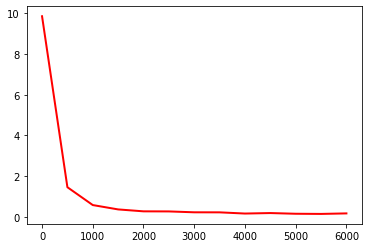

折1，训练loss: 0.14582420885562897 验证loss:0.16366638243198395


折2验证过程：
round 0  loss == 8.935591697692871
round 500  loss == 1.4942506551742554
round 1000  loss == 0.6651092171669006
round 1500  loss == 0.27635249495506287
round 2000  loss == 0.2905784249305725
round 2500  loss == 0.20955665409564972
round 3000  loss == 0.19157685339450836
round 3500  loss == 0.20434993505477905
round 4000  loss == 0.20098745822906494
round 4500  loss == 0.13618431985378265
round 5000  loss == 0.19505441188812256
round 5500  loss == 0.16578614711761475
round 6000  loss == 0.13069407641887665


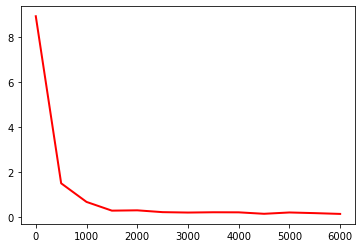

折2，训练loss: 0.13758154213428497 验证loss:0.13069407641887665


折3验证过程：
round 0  loss == 12.127442359924316
round 500  loss == 1.381622314453125
round 1000  loss == 0.5332878828048706
round 1500  loss == 0.3474647104740143
round 2000  loss == 0.2982850670814514
round 2500  loss == 0.2896336317062378
round 3000  loss == 0.24959462881088257
round 3500  loss == 0.1710769385099411
round 4000  loss == 0.2090987116098404
round 4500  loss == 0.1416061520576477
round 5000  loss == 0.14137808978557587
round 5500  loss == 0.21923036873340607
round 6000  loss == 0.1880294382572174


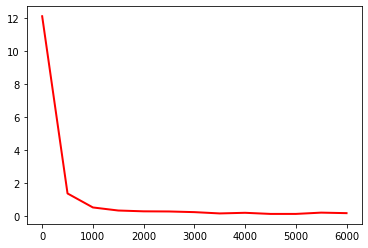

折3，训练loss: 0.1436747908592224 验证loss:0.1880294382572174


折4验证过程：
round 0  loss == 10.555232048034668
round 500  loss == 1.5512458086013794
round 1000  loss == 0.6095097661018372
round 1500  loss == 0.24632692337036133
round 2000  loss == 0.29644089937210083
round 2500  loss == 0.2185562402009964
round 3000  loss == 0.2267768830060959
round 3500  loss == 0.20698019862174988
round 4000  loss == 0.14334051311016083
round 4500  loss == 0.17944127321243286
round 5000  loss == 0.17707334458827972
round 5500  loss == 0.14880724251270294
round 6000  loss == 0.15325982868671417


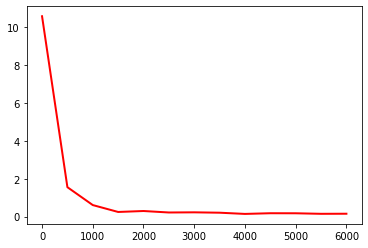

折4，训练loss: 0.15049850940704346 验证loss:0.15325982868671417


折5验证过程：
round 0  loss == 8.511272430419922
round 500  loss == 1.3435609340667725
round 1000  loss == 0.6419706344604492
round 1500  loss == 0.33762845396995544
round 2000  loss == 0.2702370584011078
round 2500  loss == 0.2630668878555298
round 3000  loss == 0.14737313985824585
round 3500  loss == 0.1997557282447815
round 4000  loss == 0.19317398965358734
round 4500  loss == 0.17366506159305573
round 5000  loss == 0.1796531230211258
round 5500  loss == 0.16090689599514008
round 6000  loss == 0.12787286937236786


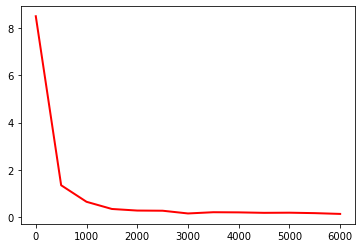

折5，训练loss: 0.22861123085021973 验证loss:0.12787286937236786


5-折验证，平均训练：0.15270452201366425 平均验证：0.16123804450035095


In [ ]:
train_l, valid_l = k_fold(train_features, train_labels)
print('{}-折验证，平均训练：{} 平均验证：{}'.format(k, float(train_l),float(float(valid_l))))

# 参数实验

通过$K$折交叉验证可以及时的发现过拟合问题，只需时刻注意训练loss与验证loss值即可

在此基础上通过调整整个MLP的参数进行参数实验，得到最好的结果

可以调整的参数有：
（默认为两个隐藏层的MLP）


*   **隐藏层数1**：hidden_size1           
*   **隐藏层数2**：hidden_size2                        
*   **小批量梯度下降**：batch_size            
*   **训练次数**：Epoch            
*   **学习率**：lr  


注：下文中出现的训练LOSS和测试LOSS中

训练LOSS指的是通过本文件在Colab上训练完毕后，利用训练集做验证跑出来的损失值

*   取三次总结果平均数，保留四位小数

测试LOSS指的是讲csv预测结果文件提交至kaggle网站得到的LOSS

*   因为小号数量有限，一天只能提交30次，因此是提交三次测试中最好的一次取kaggle网站结果，保留四位小数

二者相结合共同评估本次参数试验的结果优良程度。

发现利用下损失函数得到的结果与带入kaggle网站得到的得分结果基本一致。
$$\large loss = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$
这再次证明了此损失函数的有效性。

&emsp;&emsp;
&emsp;&emsp;

## 隐藏层数参数试验

本实验用于探究两层隐藏层的MLP中隐藏层与最终结果的关系：

在实验中固定：batch_size=100，训练次数=6000，学习率=3.5e-1

&emsp;&emsp;


|  第一层隐藏层数   | 第二层隐藏层数  | 训练LOSS    |   测试LOSS |
| :--: | :--: | :--: | :--: |     
| &emsp;&emsp; 256      | &emsp;&emsp; 128    |   0.1336 |    0.1436  |
| &emsp;&emsp; 256      |&emsp;&emsp;  64     |  0.1375 |    0.1475   |
| &emsp;&emsp; 128      | &emsp;&emsp; 64    |   **0.1206** | **0.1283** |
| &emsp;&emsp; 128      | &emsp;&emsp; 32     |  0.1325 |   0.1385    |
| &emsp;&emsp; 64      | &emsp;&emsp;  32    |    0.1516 |  0.1532    |
| &emsp;&emsp; 64      | &emsp;&emsp;  16     |   0.1575 |  0.1521    |

其中当第一层隐藏层数为128，第二层隐藏层数为64时得到的损失最小

### 原理推断：

层数较少时，因为输入维度被扩充到了331，一次减少太多层可能导致损失大量信息，后期无法拟合。
而层数过大也会导致模型过于复杂，记录了许多无关的信息，十分容易过拟合，在提交到kaggle测试平台时的效果低于本机测试（尽管使用了相同的损失函数）

&emsp;&emsp;

  
## 训练次数参数试验

本实验用于探究训练次数与最终结果的关系。在实验中固定的参数：batch_size=100，两个隐藏层数为128,64，学习率=3.5e-1因为**$K$折交叉验证**中先进行了训练，之后选取最好的再通过整个训练集进行训练，所以实际训练次数应该为表中数据的两倍。


其中当训练次数为5000次时训练LOSS和测试LOSS最小。

&emsp;&emsp;


|  &emsp;&emsp;训练次数| &emsp;&emsp;训练LOSS     |  &emsp; 测试LOSS |
| :--: | :--: | :--: |        
| &emsp;&emsp;  3000 |  &emsp;&emsp;  0.1687   |  &emsp;&emsp;0.1875 |
| &emsp;&emsp;  4000|  &emsp;&emsp;  0.1578    |  &emsp;&emsp; 0.1567 |
| &emsp;&emsp;  5000|  &emsp;&emsp;  0.1275    | &emsp;&emsp; 0.1425 |
| &emsp;&emsp;  6000 | &emsp;&emsp; **0.1206**   | &emsp;&emsp; **0.1283** |
| &emsp;&emsp; 7000| &emsp;&emsp;  0.1210      | &emsp;&emsp;  0.1375 |


### 原理推断：

当训练次数较少时，模型处于欠拟合状态，还有优化的空间，可以表现的更好

当训练次数为5000-6000左右时基本进入最优状态，再增加训练次数就会开始左右摆动，而与此同时因为机器更倾向于迎合训练集的结果，在提交至kaggle平台时有显著的退步。

&emsp;&emsp;

## 学习率参数试验

本实验用于探究两层隐藏层的MLP中学习率与最终结果的关系。在实验中固定的参数：batch_size=100，两个隐藏层数为128、64，训练次数=6000。其中当学习率为**3.5e-1**时得到的损失最小。

&emsp;&emsp;

| &emsp;&emsp;学习率 | &emsp;&emsp; 训练LOSS |  &emsp;  测试LOSS |
| :--: | :--: | :--: |      
| &emsp;&emsp; 2e-1 | &emsp;&emsp; 0.1317  |&emsp;&emsp;  0.1275 |
| &emsp;&emsp; 3e-1| &emsp;&emsp;  0.1378  | &emsp;&emsp;  0.1337 |
| &emsp;&emsp; 3.5e-1 |&emsp;&emsp;**0.1206** |&emsp;&emsp;  **0.1283** |
| &emsp;&emsp; 4e-1 | &emsp;&emsp;0.1327   |&emsp;&emsp; 0.1347 |
| &emsp;&emsp; 5e-1  |&emsp;&emsp; 0.1310  |&emsp;&emsp;  0.1375 |



### 原理推断：

因为实验中K折验证部分和正常训练都设计到下降，因此因为学习率过低没有到达最低点的情况是几乎不存在的，因此几组值之间差异不是很大

但当学习率过大时，在最后的训练阶段波动非常明显，这也验证了老师介绍的学习率和收敛的关系：
*   学习率过大时，下降速度越快，但后期出现波动，难以收敛
*   学习率过小时，下降速度较慢，但后期也比较平稳，可以收敛

本实验找到较为平稳且下降速度较快的学习率，采取最后训练阶段中得到的最优值带入测试集获取预测结果

&emsp;&emsp;

## 结论
当batch_size=100，两个隐藏层数为128,64， 训练次数=6000，学习率=3.5e-1时，得到的结果最优。

## 最终训练

参数实验结束，我们制作最终的结构函数，分为：
*  训练部分
*  测试部分
*  导出部分

将之前参数试验得到的最好参数直接运行训练
选出平均经验错误率最小的折的权重参数，然后使用全部的训练集再做一次训练，得到最后的权重与损失
将测试集带入训练好的MLP中
导出到submission.csv

In [ ]:
def train_and_pred():
    # 训练部分
    train(train_features, train_labels, None, None, best_w1, best_w2, best_w3, best_b1, best_b2, best_b3, 1)

    # 测试（生成结果）部分
    out_put = net(test_features, ans_w1, ans_w2, ans_w3, ans_b1, ans_b2, ans_b3).detach().numpy()

    # 导出部分
    torch.save([ans_w1, ans_w2, ans_w3, ans_b1, ans_b2, ans_b3], 'theta.pt')

    test_data['SalePrice'] = pd.Series(out_put.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

    print('实验结束')

## 结果提交

实验完成，直接运行之前封装好的train_and_pred()，并提交submission.csv

round 0  loss == 0.1810733526945114
round 500  loss == 0.11885397881269455
round 1000  loss == 0.22358286380767822
round 1500  loss == 0.163870707154274
round 2000  loss == 0.1809668242931366
round 2500  loss == 0.17720834910869598
round 3000  loss == 0.14854957163333893
round 3500  loss == 0.1701183319091797
round 4000  loss == 0.11913202702999115
round 4500  loss == 0.10428732633590698
round 5000  loss == 0.09686217457056046
round 5500  loss == 0.1154472753405571
round 6000  loss == 0.13375380635261536


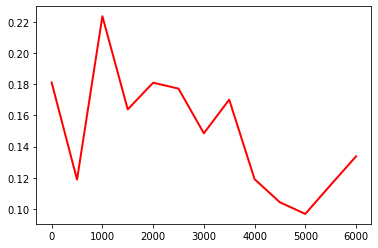

最终loss == tensor([0.5340], grad_fn=<SqrtBackward0>)
最终loss == tensor([0.5340], grad_fn=<SqrtBackward0>)
实验结束


In [ ]:
train_and_pred()

# Kaggle房价预测比赛结果

![score](https://img-blog.csdnimg.cn/1b7d37a6f086425a93e634f3944ebd20.png)

## 排名展示

截止2022年7月11日17:31分，本小组在kaggle房价测试中取得的排名为952名

![rank](https://img-blog.csdnimg.cn/709de41e92e341e7b036b94c362a0f4c.png)



# 总结
---

* 真实数据通常混合了不同的数据类型，需要进行预处理。
* 常用的预处理方法：将实值数据重新缩放为零均值和单位方法；用均值替换缺失值。
* 将类别特征转化为指标特征，可以使我们把这个特征当作一个**One-Hot**向量来对待。
* 我们可以使用**$K$折交叉验证**来选择模型并调整超参数，及时观察到过拟合现象。
* 求取损失函数时，不一定要用绝对误差，利用对数求取**相对误差**会有奇效。

# 收获
---

&emsp;&emsp;本次实验是我参与的第一次小组合作项目实验，之前都是一个人在电脑上写代码，没有与其他同学进行沟通互助，这次小组合作我们采用的是分工模式，一个人一个模块，设置好ddl，小组内通过共享ipynb的方式进行文件传递与更新。

&emsp;&emsp;我发现小组合作完成项目的效率是非常高的，最开始设计MLP的时候我一味追求更多信息，更深的层数，希望通过高复杂度让模型更优秀，但是初步调参实验结果并不尽如人意。正好因为在阶段性进度汇报时和小组其他成员沟通了这个情况，队友建议我尝试简单一点的模型，并不是模型越复杂效果就越好。其实这一点我也是知道的，但调参过程就忙于修正学习率和隐藏层规模，没有尝试删去一层看看效果。在团队协作中充分的交流有助于让我开阔思路，走出自己的怪圈。

&emsp;&emsp;今后进入社会，代码开发工作几乎不可能是一个人的任务，这次小组合作的形式对我来说是一个宝贵的经历，让我提前知晓了团队合作可能出现的问题并亲身得出应对与解决方案，这对我以后进行小组开发活动有了一定的经验与信心。

最后，感谢您的审阅！